# Classification of MNIST data with ROC calculation & Regularization Techniques
## Muhammed Ömer Faruk Selvi

# Gerekli kütüphaneler ve veriseti hazırlığı

In [52]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import tensorflow.keras.regularizers as RGL

import numpy as np

import skimage


def show(img):
    plt.imshow(img, cmap='gray')
    plt.show()


    

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# cross-val için
# train ve test setleri birleştirilip istenen oranda geri bölünebilir
# print(x_train_.shape)
# print(x_test.shape)
# x_train_ = np.concatenate((x_train_, x_test), axis=0)
# y_train_ = np.concatenate((y_train_, y_test), axis=0)


# # iki diziyi de aynı düzende karıştır
# np.random.seed(999); np.random.shuffle(x_train_)
# np.random.seed(999); np.random.shuffle(y_train_)

# # "Eğitim verisinin, sadece 5000 örneğini eğitim ve kalan kısmını validasyon için kullanınız."
# # Train kısmının 5000 adede denk gelen kısmını train için kullan. Kalan kısmı validation setine at.
# validation_split = 1.0 - (5000.0 / x_train_.shape[0])
# print("Validasyon çarpanı:",validation_split)

# split_idx = int(x_train_.shape[0]*(1.0-validation_split))
# x_train = x_train_[:split_idx]
# y_train = y_train_[:split_idx]

# x_test = x_train_[split_idx:]
# y_test = y_train_[split_idx:]


print(x_train.shape[0],"eğitim verisi,",x_test.shape[0],"doğrulama verisi bulunmaktadır.")
img_size = x_train.shape[1]
print("Görüntü boyutu",img_size,"x",img_size)


x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# one-hot kodlaması yap
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
# burası örn. 3 değerini [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] vektörüne dönüştürür





60000 eğitim verisi, 10000 doğrulama verisi bulunmaktadır.
Görüntü boyutu 28 x 28


## Rastgele bir dataya bakalım

7624


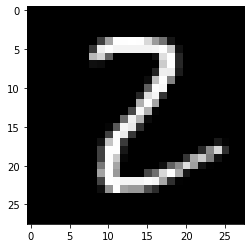

tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
(28, 28, 1)


In [3]:
idx=int(np.random.rand(1)*len(x_train))
print(idx)
show(x_train[idx])
print(y_train[idx])
# print(x_train[idx])
print(x_train[idx].shape)
# print(x_train[idx])

# Gerekli fonksiyonlar

In [65]:
# normal model
def egitim(model_ismi="model_1"):
    
    # functional model için Input katmanı
    layer_input = L.Input(shape=(img_size, img_size, 1), name='INPUT')

    lyr = L.Conv2D(32, (5,5), padding='same', activation='relu', strides=(1, 1), use_bias=False)(layer_input)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Conv2D(32, (3,3), padding='same', activation='relu', strides=(1, 1), use_bias=False)(layer_input)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Conv2D(32, (3,3), padding='same', activation='relu', strides=(1, 1), use_bias=False)(layer_input)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Flatten()(lyr)
    lyr = L.Dense(64, activation='relu', use_bias=False)(lyr)
    
    lyr = L.Dense(10, activation='softmax', use_bias=False)(lyr) # çok sınıf olması sebebiyle softmax


    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model = Model(layer_input, lyr)
    model._name = model_ismi
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()


    batch_size = 4096
    epoch_num = 100
    
    print("Eğitilmemiş haliyle modelin skorları:")
    dogrulama(model)

    train_history = model.fit(x_train, y_train, validation_data = (x_test, y_test),batch_size=batch_size,epochs=epoch_num, verbose=1)
    return model, train_history

# kernel regularizer (L1 ve L2), batch normalization ve dropout kullanılmış model
def egitim2(model_ismi="model_2"):
    
    # functional model için Input katmanı
    layer_input = L.Input(shape=(img_size, img_size, 1), name='INPUT')

    lyr = L.Conv2D(32, (5,5), padding='same', strides=(1, 1), use_bias=False, kernel_regularizer=RGL.L1L2(l1=1e-6, l2=1e-5))(layer_input)
    lyr = L.BatchNormalization()(lyr)
    lyr = L.ReLU()(lyr)
    lyr = L.Dropout(0.1)(lyr)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Conv2D(32, (3,3), padding='same', strides=(1, 1), use_bias=False, kernel_regularizer=RGL.L1L2(l1=1e-6, l2=1e-5))(layer_input)
#     lyr = L.BatchNormalization()(lyr)
    lyr = L.ReLU()(lyr)
    lyr = L.Dropout(0.1)(lyr)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Conv2D(32, (3,3), padding='same', strides=(1, 1), use_bias=False, kernel_regularizer=RGL.L1L2(l1=1e-6, l2=1e-5))(layer_input)
#     lyr = L.BatchNormalization()(lyr)
    lyr = L.ReLU()(lyr)
    lyr = L.Dropout(0.1)(lyr)
    lyr = L.MaxPooling2D((2,2), strides=(2, 2))(lyr)
    
    lyr = L.Flatten()(lyr)
    lyr = L.Dropout(0.2)(lyr)
    lyr = L.Dense(64, activation='relu', use_bias=False)(lyr)
#     lyr = L.BatchNormalization()(lyr)
#     lyr = L.ReLU()(lyr)
    
#     lyr = L.Dense(10, activation='softmax')(lyr)
    lyr = L.Dense(10, activation='softmax', use_bias=False)(lyr) # çok sınıf olması sebebiyle softmax
    


    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model = Model(layer_input, lyr)
    model._name = model_ismi
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()


    batch_size = 4096
    epoch_num = 100
    
    print("Eğitilmemiş haliyle modelin skorları:")
    dogrulama(model)

    train_history = model.fit(x_train, y_train, validation_data = (x_test, y_test),batch_size=batch_size,epochs=epoch_num, verbose=1)
    return model, train_history


def dogrulama(model):
    test_scores = model.evaluate(x_test,y_test,verbose=2)
    print("#"*20)
    print("Loss:",test_scores[0])
    print("Tutarlılık:",test_scores[1])
    print("#"*20)

def tahmin(model,samples_to_test=None):
    if samples_to_test is None:
        samples_to_test = x_test
    tahminler = model.predict(samples_to_test)
    return tahminler

def get_test_samples(maxn = 100):
    samples_to_test_x = []
    samples_to_test_y = []
    if maxn==0:
        samples_to_test_x = x_test
        samples_to_test_y = y_test
    else:
        samples_to_test_x = x_test[:maxn]
        samples_to_test_y = y_test[:maxn]
    return samples_to_test_x, samples_to_test_y

def grafik(gecmis):
    for metric_name in gecmis.history.keys():
        if metric_name[:4] != "val_":
            plt.figure(figsize=(8, 6), dpi=100)
            plt.xlabel('Eğitim Döngüsü')
            plt.ylabel(metric_name)
            plt.plot(gecmis.history[metric_name])
            plt.plot(gecmis.history["val_"+metric_name])
            plt.legend(["Eğitim", "Test"])
            plt.show()
            plt.close()

print("Gerekli fonksiyonlar tanımlandı.")

Gerekli fonksiyonlar tanımlandı.


# ROC hesaplamaları için gerekli fonksiyonlar

In [13]:
import sklearn.metrics as metrics

def calc_tpr_fpr(y_true, y_pred):
    confmtr = metrics.confusion_matrix(y_true, y_pred)
    TN = confmtr[0, 0]
    FP = confmtr[0, 1]
    FN = confmtr[1, 0]
    TP = confmtr[1, 1]
    tpr = TP/(TP+FN)
    fpr = 1-TN/(TN+FP)
    return tpr, fpr




def get_tpr_fpr(y_test_classnos, y_probs, selected_class=1):
    y_test_class = [1 if y == selected_class else 0 for y in y_test_classnos]
    y_prob = y_probs[:, selected_class]

    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_prob)):
        threshold = y_prob[i]
        y_pred_t = y_prob >= threshold
        tpr, fpr = calc_tpr_fpr(y_test_class, y_pred_t)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    print("AUC Skoru:",metrics.roc_auc_score(y_test_class, y_prob))
    return fpr_list, tpr_list

def draw_roc(fpr_list,tpr_list):
    plt.figure(figsize=(5, 5), dpi=100)#figsize=(4, 3), dpi=100
    plt.xlabel('FPR')
    plt.ylabel('TPR')
#     plt.scatter(fpr_list, tpr_list, c='b', s=0.1)
#     plt.plot(fpr_list, tpr_list, c='#d62728', ms=0.1)

#     newax = np.stack((fpr_list, tpr_list), axis=-1)
    fpr_list_, tpr_list_ = zip(*sorted(zip(fpr_list, tpr_list)))
    plt.plot(fpr_list_, tpr_list_, c='b', ms=0.1)
    
    plt.plot([0,1], [0,1], c='g', ms=0.001)
    plt.show()
    plt.close()
    

    






# y_pred = tf.one_hot(y_pred_args.astype(np.int32), depth=10)
# print(y_pred[:10],y_test[:10])

# confmat = metrics.multilabel_confusion_matrix(y_test_args, y_pred_args, labels=[i for i in range(0,10)])
# print(confmat)

# print("*"*20)
# TNs = np.sum(confmat[:,0,0])
# FNs = np.sum(confmat[:,1,0])
# TPs = np.sum(confmat[:,1,1])
# FPs = np.sum(confmat[:,0,1])
# print("Tüm confusion matrix elementlerinin toplamı:")
# print(TNs, FPs)
# print(FNs, TPs)






# plt.figure()#figsize=(4, 3), dpi=100
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# # plt.scatter(fpr_list, tpr_list, c='#d62728')
# plt.plot(fpr_list, tpr_list, c='#d62728')
# plt.show()
# plt.close()
# print(metrics.roc_auc_score(y_test_class, y_prob))


# fpr, tpr, thresholds = metrics.roc_curve(y_test, tahminler)
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# print(roc_auc_score(y_test, tahminler))


    
# def grafik_roc(confmtr):
#     TN = confmtr[0, 0]
#     FN = confmtr[1, 0]
#     TP = confmtr[1, 1]
#     FP = confmtr[0, 1]
#     _tpr = TP/(TP + FN) # TP rate
#     _fpr = 1-TN/(TN+FP) # FP rate
    
    
#     for i


# Model1 : Varsayılan ayarlar

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        288       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                401408    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                640       
Total params: 402,336
Trainable params: 402,336
Non-trainable params: 0
_____________________________________________________

60000/60000 [==============================] - 1s 15us/sample - loss: 1.4656 - accuracy: 0.9959 - val_loss: 1.4761 - val_accuracy: 0.9858
Epoch 47/100
60000/60000 [==============================] - 1s 14us/sample - loss: 1.4656 - accuracy: 0.9959 - val_loss: 1.4773 - val_accuracy: 0.9841
Epoch 48/100
60000/60000 [==============================] - 1s 15us/sample - loss: 1.4658 - accuracy: 0.9956 - val_loss: 1.4765 - val_accuracy: 0.9850
Epoch 49/100
60000/60000 [==============================] - 1s 15us/sample - loss: 1.4656 - accuracy: 0.9959 - val_loss: 1.4770 - val_accuracy: 0.9843
Epoch 50/100
60000/60000 [==============================] - 1s 14us/sample - loss: 1.4653 - accuracy: 0.9960 - val_loss: 1.4763 - val_accuracy: 0.9848
Epoch 51/100
60000/60000 [==============================] - 1s 14us/sample - loss: 1.4655 - accuracy: 0.9959 - val_loss: 1.4769 - val_accuracy: 0.9848
Epoch 52/100
60000/60000 [==============================] - 1s 14us/sample - loss: 1.4654 - accuracy: 0.995

60000/60000 [==============================] - 1s 14us/sample - loss: 1.4641 - accuracy: 0.9971 - val_loss: 1.4752 - val_accuracy: 0.9859
10000/10000 - 1s - loss: 1.4752 - accuracy: 0.9859
####################
Loss: 1.4751503440856935
Tutarlılık: 0.9859
####################


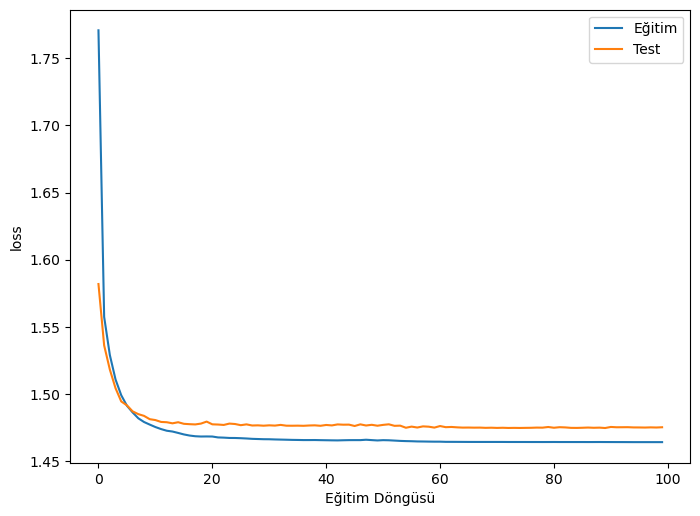

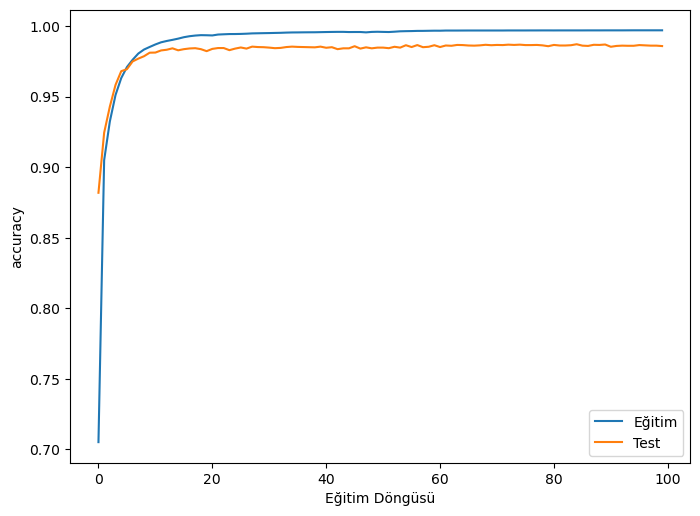

In [66]:
model1, gecmis1 = egitim("model_1")
dogrulama(model1)
grafik(gecmis1)

AUC Skoru: 0.9999566676853736


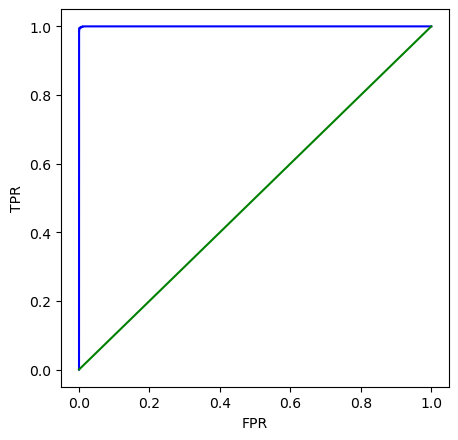

In [67]:
test_samples_x, test_samples_y = get_test_samples(0) #0: hepsi, 1000: ilk bin örnek

tahminler = tahmin(model1,test_samples_x)

# bu aşamada One vs Rest yaklaşımı için; 
# en yüksek olasılıklar ile 
# gerçek değerler kıyaslanarak doğru/yanlış hesaplamaları yapılabilir.
# Veya en yüksek değerlerin indisleri ele alınıp karşılaştırılabilir
y_pred_args=np.argmax(tahminler,axis=1)
y_test_args=np.argmax(test_samples_y,axis=1)

# print(tahminler.shape)
# print(y_pred_args.shape)
# print(y_test_args.shape)

# print(tahminler)
# print(y_pred_args)
# print(y_test_args)

fpr_lst, tpr_lst = get_tpr_fpr(y_test_args,tahminler, selected_class=1) # seçilen sınıf: 1
draw_roc(fpr_lst, tpr_lst) # çizdir

# Model 2 : Gelişmiş model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 32)        288       
_________________________________________________________________
re_lu_45 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 6272)              0   

60000/60000 [==============================] - 2s 27us/sample - loss: 1.4668 - accuracy: 0.9950 - val_loss: 1.4753 - val_accuracy: 0.9864
Epoch 44/100
60000/60000 [==============================] - 2s 26us/sample - loss: 1.4662 - accuracy: 0.9958 - val_loss: 1.4750 - val_accuracy: 0.9869
Epoch 45/100
60000/60000 [==============================] - 2s 26us/sample - loss: 1.4660 - accuracy: 0.9959 - val_loss: 1.4756 - val_accuracy: 0.9861
Epoch 46/100
60000/60000 [==============================] - 2s 26us/sample - loss: 1.4666 - accuracy: 0.9952 - val_loss: 1.4757 - val_accuracy: 0.9855
Epoch 47/100
60000/60000 [==============================] - 2s 27us/sample - loss: 1.4664 - accuracy: 0.9955 - val_loss: 1.4750 - val_accuracy: 0.9864
Epoch 48/100
60000/60000 [==============================] - 2s 27us/sample - loss: 1.4660 - accuracy: 0.9958 - val_loss: 1.4750 - val_accuracy: 0.9866
Epoch 49/100
60000/60000 [==============================] - 2s 27us/sample - loss: 1.4658 - accuracy: 0.996

60000/60000 [==============================] - 2s 26us/sample - loss: 1.4640 - accuracy: 0.9976 - val_loss: 1.4729 - val_accuracy: 0.9888
Epoch 98/100
60000/60000 [==============================] - 2s 27us/sample - loss: 1.4637 - accuracy: 0.9980 - val_loss: 1.4735 - val_accuracy: 0.9882
Epoch 99/100
60000/60000 [==============================] - 2s 28us/sample - loss: 1.4639 - accuracy: 0.9978 - val_loss: 1.4752 - val_accuracy: 0.9861
Epoch 100/100
60000/60000 [==============================] - 2s 26us/sample - loss: 1.4639 - accuracy: 0.9978 - val_loss: 1.4746 - val_accuracy: 0.9870
10000/10000 - 1s - loss: 1.4746 - accuracy: 0.9870
####################
Loss: 1.474610786819458
Tutarlılık: 0.987
####################


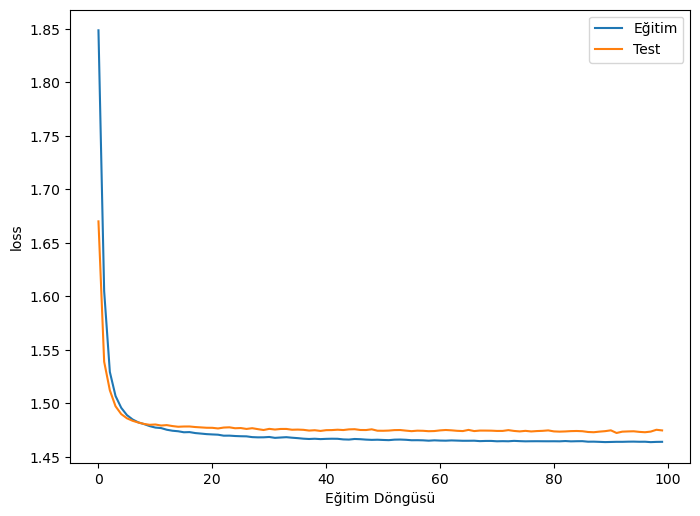

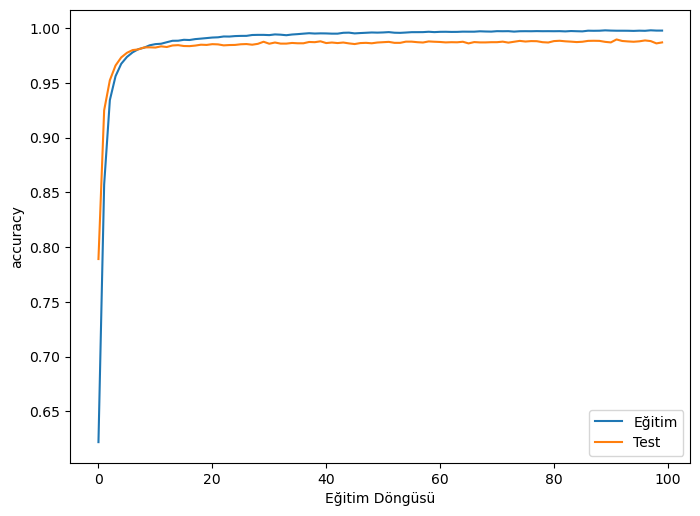

In [68]:
model2, gecmis2 = egitim2("model_2")
dogrulama(model2)
grafik(gecmis2)

AUC Skoru: 0.9998804882836279


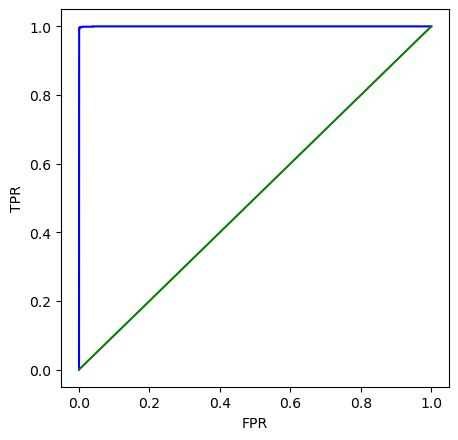

In [69]:
test_samples_x, test_samples_y = get_test_samples(0) #0: hepsi, 1000: ilk bin örnek

tahminler = tahmin(model2,test_samples_x)

# bu aşamada One vs Rest yaklaşımı için; 
# en yüksek olasılıklar ile 
# gerçek değerler kıyaslanarak doğru/yanlış hesaplamaları yapılabilir.
# Veya en yüksek değerlerin indisleri ele alınıp karşılaştırılabilir
y_pred_args=np.argmax(tahminler,axis=1)
y_test_args=np.argmax(test_samples_y,axis=1)

# print(tahminler.shape)
# print(y_pred_args.shape)
# print(y_test_args.shape)

# print(tahminler)
# print(y_pred_args)
# print(y_test_args)

fpr_lst, tpr_lst = get_tpr_fpr(y_test_args,tahminler, selected_class=1) # seçilen sınıf: 1
draw_roc(fpr_lst, tpr_lst) # çizdir

# Modelde kullanılan regülarize etme yöntemleri:

## Batch normalization
### Eğitim esnasında bir seferde gönderilen veri adedi batch olarak adlandırılır. Batch boyutu yükseldikçe, eğitimin başlarında optimum noktadan sapma miktarı da yükselebilir. Fakat eğitim devam ettikçe model daha uygun ağırlıkları alacaktır. Örnekleri tek tek öğrenmek yerine daha genel özniteliklerin öğrenilmesinde faydalıdır. Ancak batchteki veriler birbirlerinden çok uzakta olabilir. Bu katman sayesinde eğitim aşamasında hareketli ortalama hesaplamalarıyla bir katmanın çıkışının ortalaması 0'a, standart sapması 1'e yaklaştırılır.

## Parameter norm penalties (kernel reg.)
### Ağırlık, bias veya nöron çıktısına parametre regülarizasyonu uygulanabilir. Bu modelde kernel regülarizasyonu kullanılmıştır. Hem L1 hem de L2 normlarına göre ağırlıklar regüle edilmektedir.

## Dropout
### Belirtilen oranda rastgele girdi verileri görmezden gelinir. Her iterasyonda rastgele olarak giriş verilerinden bir kısmı atılır. Böylece modelin ezberlemesi (overfit) ihtimali düşürülür.